In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13085730942996709780, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4955793861089033005
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10787260222043096027
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150664704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4362299375934798444
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
%matplotlib inline
import os
import sys
import glob
import numpy as np
from random import shuffle
import shutil
import imageio as im

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from tensorflow import keras
from tensorflow.keras import optimizers, initializers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, initializers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense, BatchNormalization, Input, Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import concatenate

In [ ]:
img_width, img_height = 133, 108
if K.image_data_format() == 'channels_first':
  input_shape = (1, img_width, img_height)
else:
  input_shape = (img_width, img_height, 1)

In [ ]:
glorot_normal = initializers.he_normal()

def naive_inception_module(layer_in):
  conv1_1 = Conv2D(filters = 4, kernel_size=(10, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(layer_in)
  conv1_2 = Conv2D(filters = 4,kernel_size=(5, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(conv1_1)
  conv1_3 = Conv2D(filters = 4,kernel_size=(1, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(conv1_2)
  
  conv2_1 = Conv2D(filters = 4,kernel_size=(13, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(layer_in)
  conv2_2 = Conv2D(filters = 4,kernel_size=(3, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(conv2_1)
  conv2_3 = Conv2D(filters = 4,kernel_size=(1, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(conv2_2)

  conv3_1 = Conv2D(filters = 4, kernel_size=(7, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(layer_in)
  conv3_2 = Conv2D(filters = 4, kernel_size=(5, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(conv3_1)
  conv3_3 = Conv2D(filters = 4, kernel_size=(1, 1), strides = (2, 2), padding='same', activation='relu', kernel_initializer=glorot_normal)(conv3_2)
  
  
  layer_out = concatenate([conv1_3, conv2_3, conv3_3], axis=-1)
  return layer_out
 

visible = Input(shape=input_shape)
layer = naive_inception_module(visible)

flatten = Flatten()(layer)
dense1 = Dense(128, kernel_initializer=glorot_normal, activation='relu')(flatten)
drop1 = Dropout(0.25)(dense1)
dense2 = Dense(128, kernel_initializer=glorot_normal, activation='relu')(drop1)
dense3 = Dense(2, kernel_initializer=glorot_normal, activation = 'softmax')(dense2)

model = Model(inputs=visible, outputs=dense3)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 133, 108, 1) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 67, 54, 4)    44          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 67, 54, 4)    56          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 67, 54, 4)    32          input_4[0][0]                    
____________________________________________________________________________________________

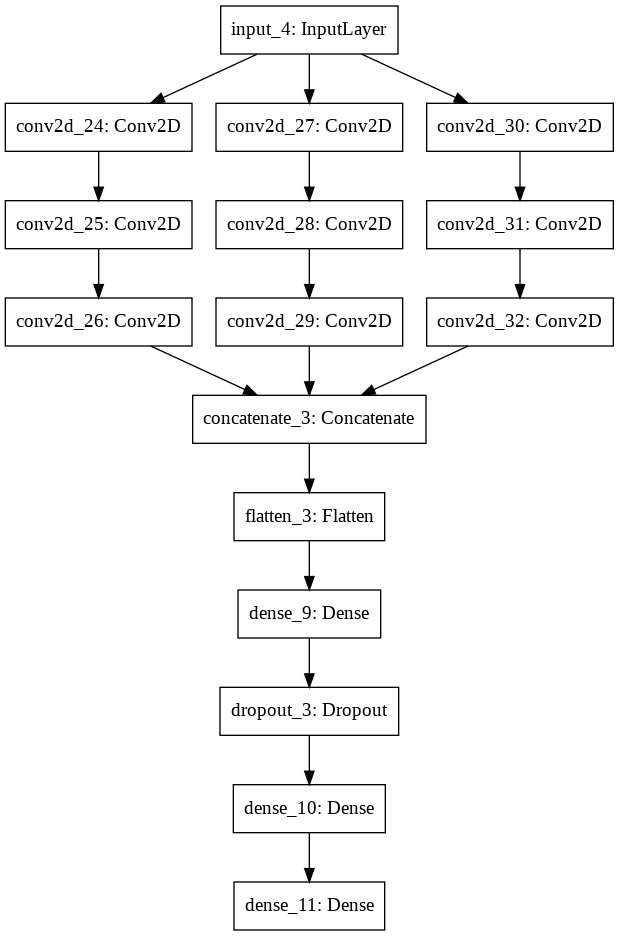

In [ ]:
plot_model(model)

In [ ]:
adam = optimizers.Adam()
adadelta = optimizers.Adadelta()
nadam = optimizers.Nadam()
sgd = optimizers.SGD()
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = nadam,
    metrics = ['accuracy'])

In [ ]:
batch_size = 256
num_classes = 2
main_dir = '/content/drive/-/modeling/PFclass'
train_data_dir = main_dir + '/train'
val_data_dir = main_dir + '/val'
test_data_dir = main_dir + '/test'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_directory(
    directory = train_data_dir,
    target_size = (img_width, img_height),
    color_mode = 'grayscale',
    classes = ['point', 'flow'],
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True
)

validation_data_generator = val_datagen.flow_from_directory(
    directory = val_data_dir,
    target_size = (img_width, img_height),
    color_mode = 'grayscale',
    classes = ['point', 'flow'],
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True
)

test_data_generator = test_datagen.flow_from_directory(
    directory = test_data_dir,
    target_size = (img_width, img_height),
    color_mode = 'grayscale',
    classes = ['point', 'flow'],
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True
)

Found 10697 images belonging to 2 classes.
Found 2292 images belonging to 2 classes.
Found 2292 images belonging to 2 classes.


In [ ]:
%%time
nb_train_samples = 10697
nb_val_samples = 2292
epochs = 50
callbacks = [
             keras.callbacks.ModelCheckpoint("my_model.h5", monitor = 'val_accuracy', save_best_only=True, save_weights_only=False, mode='auto'),
             keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)
             ]
history = model.fit_generator(
    train_data_generator,
    steps_per_epoch = nb_train_samples//batch_size,
    epochs = epochs,
    validation_data = validation_data_generator,
    validation_steps = nb_val_samples//batch_size,
    callbacks = callbacks
    )
#model.save_weight(model_weight_name)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
41/41 [==============================] - 10539s 257s/step - loss: 0.6017 - accuracy: 0.6771 - val_loss: 0.3481 - val_accuracy: 0.9126
Epoch 2/50
41/41 [==============================] - 32s 771ms/step - loss: 0.2926 - accuracy: 0.8899 - val_loss: 0.1332 - val_accuracy: 0.9590
Epoch 3/50
41/41 [==============================] - 31s 768ms/step - loss: 0.1053 - accuracy: 0.9687 - val_loss: 0.0513 - val_accuracy: 0.9810
Epoch 4/50
41/41 [==============================] - 33s 794ms/step - loss: 0.0394 - accuracy: 0.9882 - val_loss: 0.0207 - val_accuracy: 0.9932
Epoch 5/50
41/41 [==============================] - 32s 775ms/step - loss: 0.0188 - accuracy: 0.9949 - val_loss: 0.0137 - val_accuracy: 0.9961
Epoch 6/50
41/41 [==============================] - 32s 769ms/step - loss: 0.0097 - accuracy: 0.9983 - val_loss: 0.0094 - val_accuracy: 0.9971
Epoch 7/50
41/41 [==============================] - 32s 771ms/st

In [ ]:
y_pred = []
y_true = []

In [ ]:
rad2 = '/content/drive/-modeling/PFclass/test/flow'
rad2_list = []
for root, dirs, files in os.walk("/content/drive/-/modeling/PFclass/test/flow"):
    for file in files:
        if file.endswith(".png"):
            rad2_list.append(os.path.join(root, file))
for img in rad2_list:
  img_path = img
  img = image.load_img(img_path,color_mode='grayscale', target_size=(img_width, img_height))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images)
  y_pred.append(classes.argmax())
  y_true.append(1)

In [ ]:
rad3 = '/content/drive/-/modeling/PFclass/test/point'
rad3_list = []
for root, dirs, files in os.walk("/content/drive/-/modeling/PFclass/test/point"):
    for file in files:
        if file.endswith(".png"):
            rad3_list.append(os.path.join(root, file))
for img in rad3_list:
  img_path = img
  img = image.load_img(img_path,color_mode='grayscale', target_size=(img_width, img_height))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images)
  #print("Predicted class is:",classes)
  y_pred.append(classes.argmax())
  y_true.append(0)

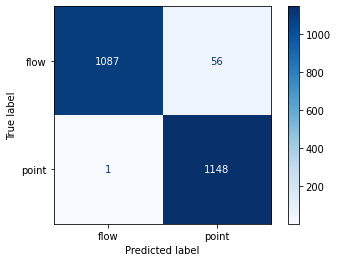

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp  = ConfusionMatrixDisplay(confusion_matrix(np.array(y_true, dtype=int), np.array(y_pred, dtype = int)), display_labels=['flow', 'point',] )
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()